In [12]:
import pandas
import warnings
from matplotlib import pyplot
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder
from sksurv.linear_model import CoxnetSurvivalAnalysis
from deps.data import load_metadata
from deps.logger import logger
from deps.data import load_raw_data, load_data
from hcve_lib.functional import pipe
from hcve_lib.data import to_survival_y_records, get_X, get_survival_y
from hcve_lib.cv import train_test
from hcve_lib.utils import list_to_dict_index
from sklearn.model_selection import KFold
from hcve_lib.cv import cross_validate, predict_survival, lm_cv, kfold_cv
from hcve_lib.evaluation_functions import compute_metrics_folds, c_index
from hcve_lib.cv import lco_cv
from hcve_lib.data import format_identifier_long
from hcve_lib.transformers import MiceForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

logger.setLevel('DEBUG')
pandas.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'
pyplot.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
metadata = load_metadata()
data = load_data(metadata)
raw_data = load_raw_data()
raw_data_subset = raw_data.loc[data.index]

Raw data
	n cohorts=21
	n individuals=52,585

Baseline visit kept
 	n individuals removed=5,529

 	n individuals=47,056

HF cohorts removed
	n cohorts removed=3: hfgr, timechf, leitzaran
	n individuals removed=1,073

	n cohorts=18
	n individuals=45,983

No outcome cohorts removed
	n cohorts removed=5: biomarcoeurs, dyda, epath, iblomaved, stophf
	n individuals removed=3,077

	n cohorts=13
	n individuals=42,906

Missing HF data cohorts removed
	n cohorts removed=6: adelhyde, gecoh, r2c2, reve(1-2), stanislas, styrianvitd
	n individuals removed=6,209

	n cohorts=7
	n individuals=36,697

Missing blood pressure measurements
 	n individuals removed=434

 	n individuals=36,263

Providing missing PP for 3075individuals

HF individuals at baseline removed
 	n individuals removed=2,953

 	n individuals=33,310

Missing outcome individuals removed
 	n individuals removed=904

 	n individuals=32,406

Final dataset
	n individuals=32,406
	n cohorts=7



In [14]:
for column in data.columns:
    print(f'{len(data[column].unique())}: {format_identifier_long(column, metadata)}')

32406: [IDNR] IDNR
7: [STUDY_NUM] Numeric study identifier
7: [STUDY] STUDY
1: [VISIT] VISIT
2: [SEX] Gender
16090: [AGE] Age
1878: [BW] Body weight
883: [BH] Body height
13216: [BMI] Body-mass index_data
4: [SMK] Smoking status
3: [DRK] Alcohol intake
3: [DIABETES] History of diabetes
3: [HCV] History of cardiovascular disease
3: [HCAD] History of coronary artery disease
3: [HPAD] History of peripheral artery disease
3: [HAF] History of atrial fibrillation
3: [HCEREBROV] History of cerebrovascular incident
3: [TRT_AH] Intake of antihypertensive medication
3: [TRT_ACE] Intake of angiotensin converting enzyme inhibitors
3: [TRT_CCB] Intake of calcium channel blockers
3: [TRT_DIUR] Intake of diuretics
3: [TRT_BB] Intake of beta-blokcers
3: [TRT_ARB] Intake of angiotensin II receptor blockers
3: [TRT_LIP] Intake of lipid-lowering medication
471: [SBP] Systolic blood pressure
308: [DBP] Diastolic blood pressure
189: [HR] Heart rate
408: [PP] Pulse pressure
557: [SOK] Sokolow-Lyon index_dat

In [15]:
for column in data.columns:
    if len(data[column].unique()) < 10:
        data.loc[:, column] = data[column].astype('category')
    print(f'{data[column].dtype}: {format_identifier_long(column, metadata)}')

int64: [IDNR] IDNR
category: [STUDY_NUM] Numeric study identifier
category: [STUDY] STUDY
category: [VISIT] VISIT
category: [SEX] Gender
float64: [AGE] Age
float64: [BW] Body weight
float64: [BH] Body height
float64: [BMI] Body-mass index_data
category: [SMK] Smoking status
category: [DRK] Alcohol intake
category: [DIABETES] History of diabetes
category: [HCV] History of cardiovascular disease
category: [HCAD] History of coronary artery disease
category: [HPAD] History of peripheral artery disease
category: [HAF] History of atrial fibrillation
category: [HCEREBROV] History of cerebrovascular incident
category: [TRT_AH] Intake of antihypertensive medication
category: [TRT_ACE] Intake of angiotensin converting enzyme inhibitors
category: [TRT_CCB] Intake of calcium channel blockers
category: [TRT_DIUR] Intake of diuretics
category: [TRT_BB] Intake of beta-blokcers
category: [TRT_ARB] Intake of angiotensin II receptor blockers
category: [TRT_LIP] Intake of lipid-lowering medication
float6

In [16]:
import pickle

with open('./data/prediction.data', 'rb') as file:
    results = pickle.load(file)


/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.24.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [17]:
from hcve_lib.tracking import load_pickled_artifact
from hcve_lib.visualisation import b, h2
import mlflow
from mlflow.tracking import MlflowClient
from typing import Any
import pickle
import yaml
from hcve_lib.data import format_identifier
from toolz.curried import valmap, partial
from toolz import valfilter, identity
from pandas import DataFrame, Series
import plotly.express as px
from hcve_lib.serialization import to_json_serializable
from hcve_lib.evaluation_functions import compute_metric_groups


for evaluation_type in ('reproduce', 'lco', 'lm'):
    h2(evaluation_type)
    runs = mlflow.search_runs('0')
    last_run = runs[runs['tags.mlflow.parentRunId'].isna() & (runs['params.cv'] == evaluation_type)].iloc[0]
    result = load_pickled_artifact(last_run['run_id'], 'result')

    removed_features = pipe(
        result['column_masks'],
        valmap(lambda mask: valfilter(identity, mask)),
        valmap(lambda mask: list(mask)),
        valmap(lambda mask: map(partial(format_identifier, metadata=metadata), mask)),
        valmap(lambda mask: list(mask)),
    )
    b('Removed features')
    print(yaml.dump(removed_features))
    metrics_group = compute_metric_groups(c_index, result['predictions'], raw_data_subset.groupby('STUDY'))
    # for fold_name, fold in result['predictions'].items():
        # print(len(fold['model'][-1].coef_[0]))
        # print(Series(fold['model'][-1].coef_, index=fold['model'][-1].get_feature_names()))
    fig = px.imshow(
        DataFrame(metrics_group),
        labels=dict(x="Trained on", y="Tested on", color="c-index"),
    )
    fig.show()



/home/sitnarf/.local/share/virtualenvs/homage-fl-Ms4N7PDp/lib/python3.9/site-packages/dash_bootstrap_components/_table.py:5: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



train_test:
- Sokolow-Lyon index_data
- Cornell index_data



ASCOT: []
FLEMENGHO: []
HEALTHABC:
- History of atrial fibrillation
- Sokolow-Lyon index_data
- Cornell index_data
HULL_LIFELAB:
- Intake of lipid-lowering medication
- Sokolow-Lyon index_data
- QRS duration
- Cornell index_data
HVC:
- Alcohol intake
- Sokolow-Lyon index_data
- Cornell index_data
PREDICTOR:
- Intake of lipid-lowering medication
- Sokolow-Lyon index_data
- QRS duration
- Cornell index_data
PROSPER:
- History of atrial fibrillation
- Intake of lipid-lowering medication
- Sokolow-Lyon index_data
- QRS duration
- Cornell index_data



ASCOT: []
FLEMENGHO: []
HEALTHABC:
- History of atrial fibrillation
- Sokolow-Lyon index_data
- Cornell index_data
HULL_LIFELAB:
- Intake of lipid-lowering medication
- Sokolow-Lyon index_data
- QRS duration
- Cornell index_data
HVC:
- Alcohol intake
- Sokolow-Lyon index_data
- Cornell index_data
PREDICTOR:
- Intake of lipid-lowering medication
- Sokolow-Lyon index_data
- QRS duration
- Cornell index_data
PROSPER:
- History of atrial fibrillation
- Intake of lipid-lowering medication
- Sokolow-Lyon index_data
- QRS duration
- Cornell index_data



In [18]:
print(yaml.dump(to_json_serializable(metrics_group)))

ASCOT:
  ASCOT: null
  FLEMENGHO: 0.6002263258062857
  HEALTHABC: 0.5
  HULL_LIFELAB: 0.5
  HVC: 0.5
  PREDICTOR: 0.5
  PROSPER: 0.5
FLEMENGHO:
  ASCOT: 0.6582590829875374
  FLEMENGHO: null
  HEALTHABC: 0.5754372206762797
  HULL_LIFELAB: 0.5167481119502443
  HVC: 0.6110133266281117
  PREDICTOR: 0.6298785085881861
  PROSPER: 0.5534729190138443
HEALTHABC:
  ASCOT: 0.7506043006108258
  FLEMENGHO: 0.8462013270922277
  HEALTHABC: null
  HULL_LIFELAB: 0.5316970235450911
  HVC: 0.6112647724415389
  PREDICTOR: 0.7064599916212819
  PROSPER: 0.6555251227106543
HULL_LIFELAB:
  ASCOT: 0.5016696366804985
  FLEMENGHO: 0.5663803302299264
  HEALTHABC: 0.567226578969559
  HULL_LIFELAB: null
  HVC: 0.5260246416897159
  PREDICTOR: 0.5707247591118559
  PROSPER: 0.6010360863416242
HVC:
  ASCOT: 0.5110381728582697
  FLEMENGHO: 0.6481148089090067
  HEALTHABC: 0.48706720634117545
  HULL_LIFELAB: 0.5207981637790612
  HVC: null
  PREDICTOR: 0.5873481357352325
  PROSPER: 0.49855902807738106
PREDICTOR:
  ASCOT: 0

# Hyperparams feature importance

In [91]:
from optuna import Study
from mlflow.entities import Run
import optuna
from mlflow import set_tracking_uri, get_experiment, get_experiment_by_name
from run_lco_optimized import METHODS_DEFINITIONS

set_tracking_uri('http://localhost:5000')

def is_root_run(_runs: DataFrame) -> Series:
    return _runs['tags.mlflow.parentRunId'].isna()


def get_completed_runs(experiment_name: str) -> DataFrame:
    _runs = mlflow.search_runs(get_experiment_by_name(experiment_name).experiment_id)
    return _runs[_runs['status'] == 'FINISHED']

def get_last_run(_runs: DataFrame, condition: Any) -> Series:
    return _runs[condition].iloc[0]

runs = get_completed_runs('lco_optimized')


def get_study(run_id: str) -> Study:
    return load_pickled_artifact(run_id, 'study')


for method_name in METHODS_DEFINITIONS.keys():
    h2(method_name)
    last_run = get_last_run(runs, is_root_run(runs) & (runs['tags.method_name'] == method_name))
    study = get_study(last_run['run_id'])
    print(study.best_trial.user_attrs['hyperparameters'])
    optuna.visualization.plot_optimization_history(study).show()
    # optuna.visualization.plot_edf(study).show()
    # optuna.visualization.plot_param_importances(result).show()
    # optuna.visualization.plot_parallel_coordinate(study).show()

{'estimator': {'l1_ratio': 0.001524599887137823}}


{'estimator': {'learning_rate': 0.7312075046699227, 'max_depth': 2, 'n_estimators': 95, 'min_samples_split': 27, 'min_samples_leaf': 137, 'max_features': 'log2', 'subsample': 0.40294583605008727}}


{'estimator': {'n_estimators': 23, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 158, 'max_features': 'log2', 'oob_score': True}}


In [20]:
runs = get_completed_runs('lco')
last_run = get_last_run(runs, is_root_run(runs) & (runs['tags.method_name'] == 'coxnet'))
result = load_pickled_artifact(last_run['run_id'], 'result')

## Brier scores

In [80]:
from sksurv.metrics import brier_score

for fold_name, fold in result['predictions'].items():
    b(fold_name)
    try:
        print(brier_score(
            fold['y_train'],
            fold['y_true'],
            [fn(365*5) for fn in fold['model'] \
                .predict_survival_function(fold['X_test'])],
            365*5,
        )[1])
    except Exception as e:
        print(e)

[0.03286422]


[0.00935532]


[0.07122869]


[0.21747847]


[0.02551182]


[0.02435793]


all times must be within follow-up time of test data: [6; 1478[


## Survival functions

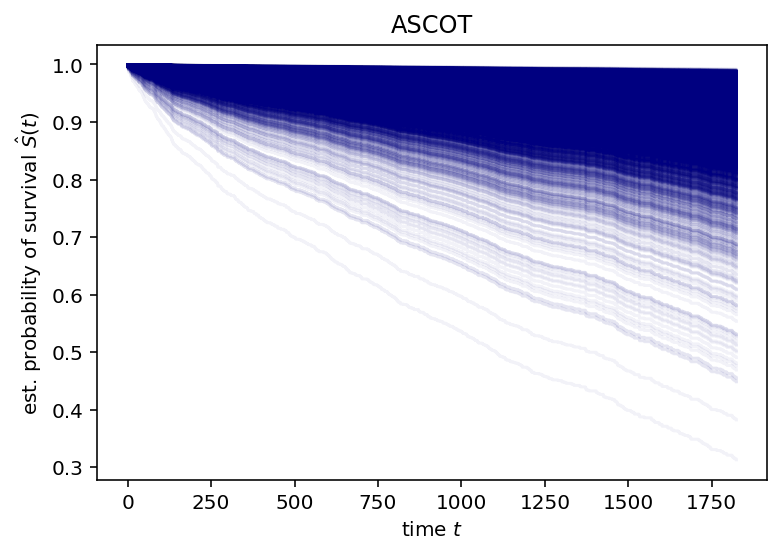

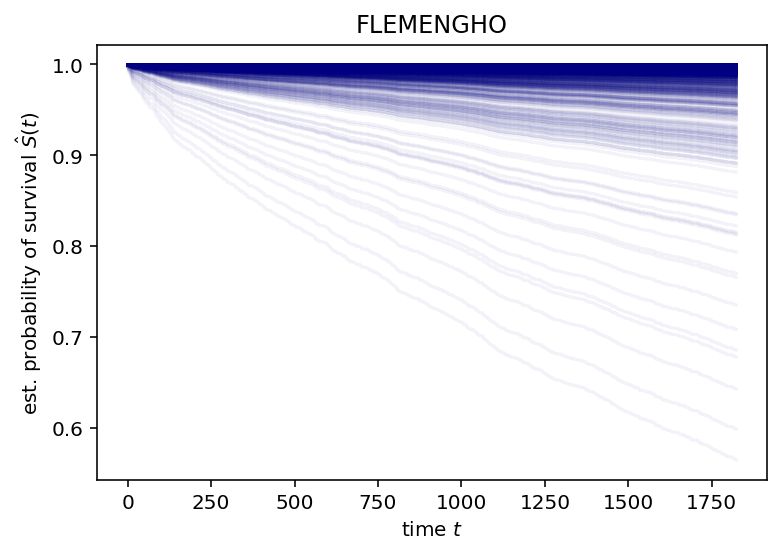

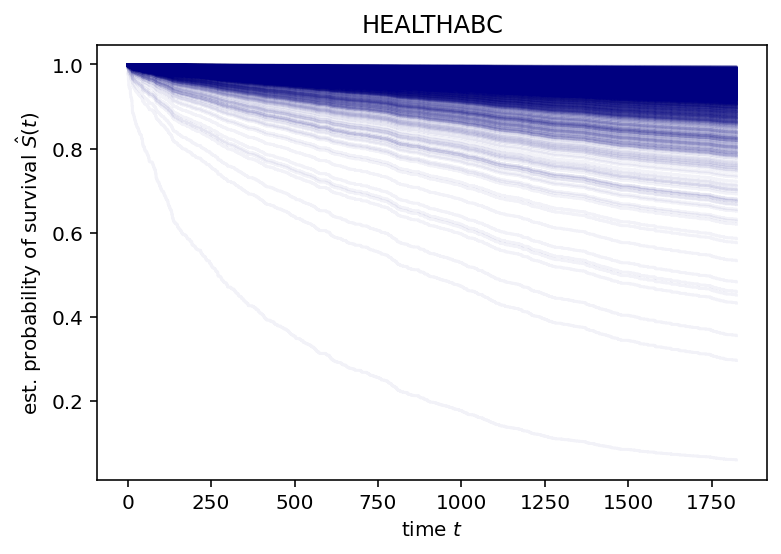

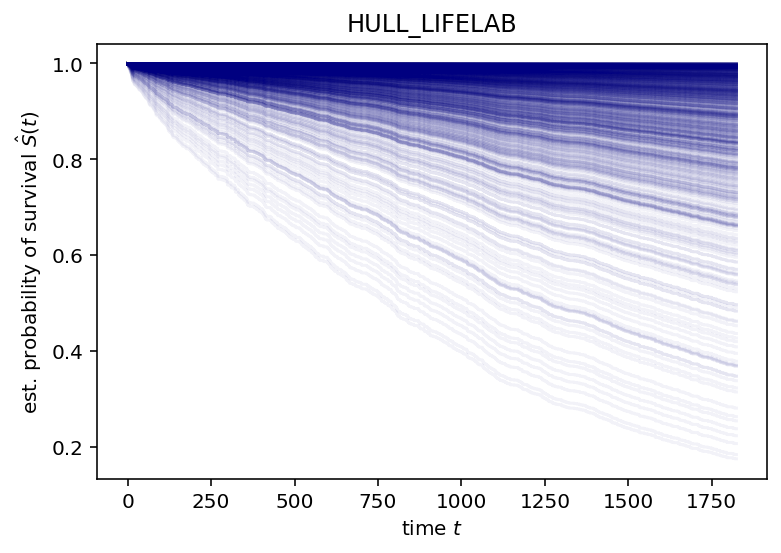

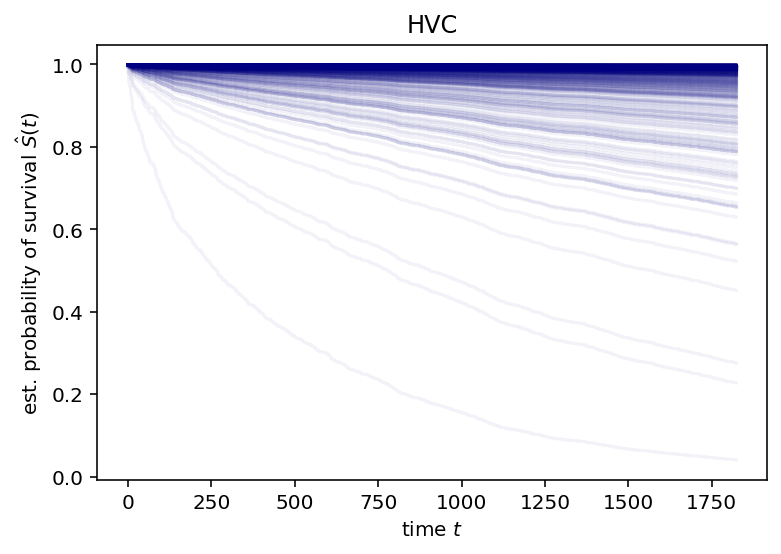

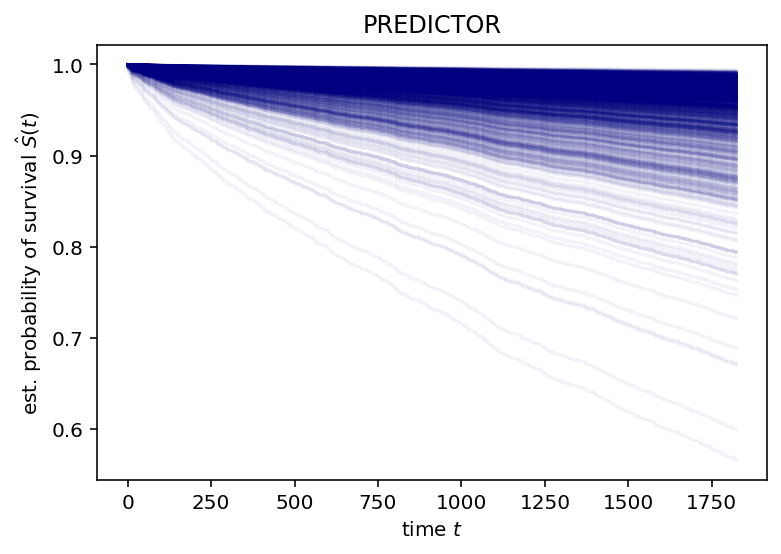

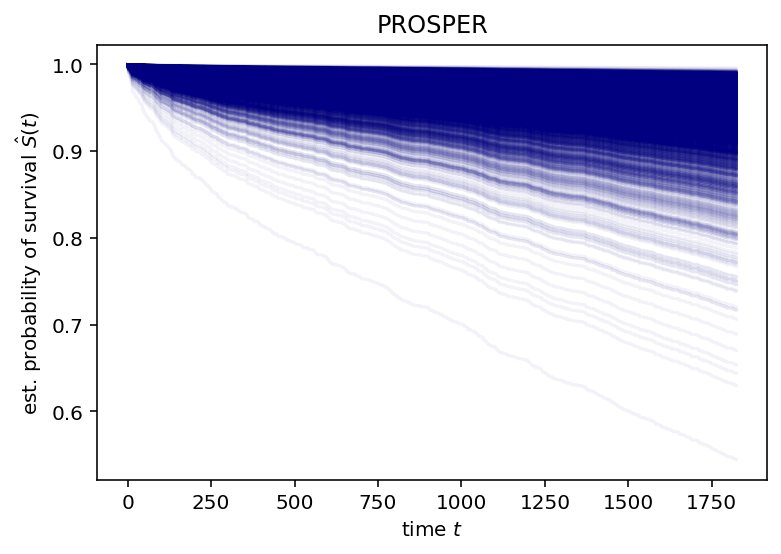

In [84]:
from numpy import arange
from toolz import take

for fold_name, fold in result['predictions'].items():
    pyplot.figure()
    pyplot.title(fold_name)
    y_survival = fold['model'].predict_survival_function(fold['X_test'])
    for step_function in y_survival:
        step_x = list(arange(0, 365*5, step=1))
        pyplot.step(step_x, step_function(step_x), where="post", c='navy', alpha=0.05)
        pyplot.gca().ticklabel_format(useOffset=False, style='plain')
        pyplot.ylabel("est. probability of survival $\hat{S}(t)$")
        pyplot.xlabel("time $t$")
    pyplot.show()

In [88]:
from common import get_variables_cached

data, metadata, X, y = get_variables_cached()
